In [17]:
import sys
import yaml
sys.path.append('../')
import os
import torch
from misc import yaml_util as yu
sys.path.append('../dataset')
sys.path.append('../module')
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from misc import character_analysis as ca


In [18]:
data_name = "one_dim_cyclic"
model_name = "subgroup_detection"
train_name = "baseline"
with open(f"""../cfg_data/{data_name}.yaml""", "rb") as f:
    cfg_data = yaml.safe_load(f)

data = yu.load_component(cfg_data) 

loader = DataLoader(data, batch_size=32,
                        shuffle=False, 
                        num_workers=1,
                        )

exp_name = f"{data_name}_{model_name}_{train_name}"

exppath = os.path.join("../dnftresult", exp_name)
if not os.path.exists(exppath):
    raise ValueError
model_path = f"{exppath}/model.pt"
model = torch.load(model_path)
model = model.to(0)
model

./dataset/cyclic_group_signal.py


SubgroupNFT(
  (encoder): MLPEncoder(
    (activation_fxn): Tanh()
    (net): Sequential(
      (0): MaskFlatLinear()
      (1): Tanh()
      (2): MaskFlatLinear()
      (3): Tanh()
      (4): MaskFlatLinear()
    )
  )
  (decoder): MLPDecoder(
    (activation_fxn): Tanh()
    (net): Sequential(
      (0): MaskFlatLinear()
      (1): Tanh()
      (2): MaskFlatLinear()
      (3): Tanh()
      (4): MaskFlatLinear()
    )
  )
)

In [40]:
import sys
import random
from itertools import cycle
from einops import repeat

sys.path.append("../")
import torch
from torch.utils.data import DataLoader
import yaml
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import copy
import numpy as np

from misc import yaml_util as yu
from module.subgroup_nft import SubgroupNFT
from tqdm import tqdm

from misc.laplacian import tracenorm_of_normalized_laplacian, make_identity_like

from torch import nn, Tensor
import matplotlib.pyplot as plt


class SubgroupDetector:
    def __init__(self, nft_model, data, writer, device) -> None:
        self.data = data
        self.loader = DataLoader(self.data, batch_size=64, shuffle=False, num_workers=1)
        self.writer = writer
        self.device = device
        self.nft_model = nft_model.eval().to(dtype=torch.float64).to(device=self.device)

        self.Ms:Tensor|None = None
        self.change_of_basis = None

    def init_rep_matrices(self) -> None:
        M_list = []
        for signal, _ in self.loader:
            self.nft_model(signal.to(device=self.device))  # compute M
            M_list.append(self.nft_model.dynamics.M.clone().detach())
        self.Ms = torch.cat(M_list)
        assert self.Ms.shape[0] == self.data.num_data

    def simultaneous_diagonalization(self) -> None:
        """
        Find a (complex valued) matrix P such that the matrices {PM(g)P^{-1}} become block matrices.
        """
        self.change_of_basis = optimize_bd_cob(mats=self.Ms)
       



In [41]:
subgroup_detector = SubgroupDetector(
    nft_model=model,
    data=data,
    writer=SummaryWriter("./dnftresult/vanillaX"),
    device=torch.device(0),
)

In [46]:
subgroup_detector.init_rep_matrices()

In [47]:
import torch
import torch.nn as nn
from einops import repeat
from misc.laplacian import tracenorm_of_normalized_laplacian, make_identity_like
from tqdm import tqdm
import numpy as np


'''
Automated Block Diagonalization (Maehara et al.)
This code is the python rendition of the algorithm publicized at
http://www.misojiro.t.u-tokyo.ac.jp/~maehara/commdec/

'''

from scipy.sparse.linalg import eigs
from scipy.sparse import csc_matrix

def comm(A, X):
    return A @ X - X @ A

def multiply(A, v):
    n = A[0].shape[1]
    N = len(A)
    X = np.reshape(v, (n, n))
    W = np.zeros((n, n))
    for k in range(N):
        W += comm(A[k].T, comm(A[k], X)) + comm(A[k], comm(A[k].T, X))
    W += np.eye(n) * np.trace(X)
    return W.reshape(n*n)


'''
Simultaneously Block Diagonalizing N matrices of shape n x n.
A :the matrix of shape  N x n x n. 
'''
def commdec(A, printSW=1, pickup=10, krylovth=1e-8):
    N = len(A)
    n = A[0].shape[1]

    # Settings
    krylovth = krylovth
    krylovit = n**2
    maxdim = n
    pickup = pickup

    v = [np.random.randn(n**2)]
    v[0] /= np.sqrt(v[0] @ v[0])
    H = csc_matrix((n**2, n**2), dtype=float)

    for j in tqdm(range(krylovit)):
        w = multiply(A, v[j])
        for i in range(max(0, j-1), j+1):
            H[i, j] = v[i] @ w
            w -= H[i, j] * v[i]
        a = np.sqrt(w @ w)

        if (a < krylovth) or (j == krylovit-1):
            break

        H[j+1, j] = a
        v.append(w / a)

    H = H[:j+1, :j+1]
    H = (H + H.T) / 2
    Q = np.column_stack(v)

    d, Y= eigs(H, k=maxdim, which='SM')
    #print(Y.shape, d.shape)

    Y = Y.reshape([Y.shape[0], -1])
    d = np.sqrt(np.diag(d)/(4*n))
    e = d[pickup-1]

    X = np.zeros([n**2,1]).astype(np.complex128)

    for i in range(pickup):
        #print(X.shape, Y[:, [0]].shape)
        X = X + Y[:,[i]]
    X = np.reshape(Q @ X, (n, n))
    D, P = np.linalg.eig(X + X.T)

    if printSW > 0:
        print(f"""err = {e}""")
    if printSW > 1:
        print('small eigs (normalized):')
        len_d = min(3+pickup, d.shape[0])
        for i in range(len_d):
            print(f'{i+1}: err = {d[i]:.3e}')



    return P, e



In [49]:
P, e = commdec(subgroup_detector.Ms.detach().to("cpu").numpy())

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
 99%|█████████▉| 99/100 [00:46<00:00,  2.12it/s]

err = [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 6.45762927+0.j]


In [50]:
print(e)

[0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 6.45762927+0.j]


In [64]:
subgroup_detector.Ms.shape

torch.Size([30000, 10, 10])

In [67]:
Ms_np = subgroup_detector.Ms.detach().to("cpu").numpy()
print(Ms_np.shape)

(30000, 10, 10)


(10, 10)

In [68]:
from numpy.linalg import inv

In [76]:
block_Ms = np.abs(inv(P) @ Ms_np @ P)

In [77]:
block_Ms.shape

(30000, 10, 10)

[[9.81977148e-01 2.77797201e-01 4.72725876e-03 1.73695089e-03
  3.96495079e-02 4.67260415e-02 4.78720024e-02 6.91094543e-02
  7.31632899e-02 2.98229908e-02]
 [2.94947213e-01 9.45896631e-01 5.68798454e-02 1.53299987e-02
  1.18379397e-02 2.92770652e-02 3.01238840e-02 2.40866090e-02
  7.07884090e-02 2.36133773e-02]
 [5.39663539e-02 8.81770868e-03 8.33349446e-01 5.45067555e-01
  5.00052502e-02 3.18732592e-02 7.55010386e-03 7.31238040e-03
  2.45876096e-02 4.10517996e-02]
 [1.12366085e-02 4.98331738e-02 5.44829858e-01 8.43996623e-01
  3.49781072e-02 8.07104106e-02 4.53255015e-02 3.85854435e-02
  5.24614344e-02 2.98479528e-02]
 [4.33542779e-02 3.21901794e-02 3.52074333e-02 2.78199312e-03
  2.15812865e-01 9.76162689e-01 2.75439904e-02 2.49422840e-02
  6.13695461e-02 4.43291427e-02]
 [4.27895308e-02 2.11081354e-02 1.52201059e-02 2.42331338e-02
  1.00645822e+00 7.27107344e-02 7.42641230e-02 1.85059864e-02
  1.79255353e-03 2.80208412e-02]
 [3.44717906e-02 6.78423142e-04 5.04323185e-02 1.57239783e

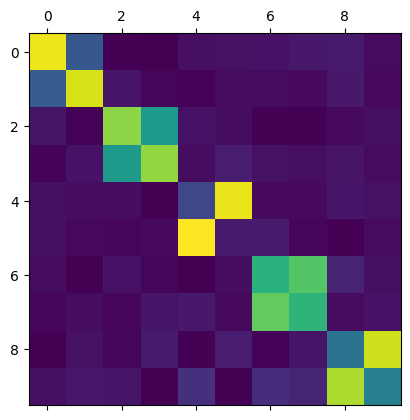

[[1.42521948e-01 9.77140953e-01 1.27932018e-02 7.53410085e-02
  7.66215199e-02 7.01697290e-03 1.97488467e-02 2.85852462e-02
  2.79805255e-02 2.77450083e-02]
 [9.89171295e-01 1.17777531e-01 7.08784135e-03 7.99135889e-02
  3.21022057e-02 1.14692271e-01 8.15316098e-03 9.54664294e-03
  6.42386647e-02 1.83376072e-02]
 [5.29167049e-02 1.19419793e-01 9.52772281e-01 2.96544822e-01
  2.01835925e-02 4.78427820e-02 7.55123259e-03 7.27739092e-03
  1.80236318e-02 6.97672936e-03]
 [9.74914888e-03 1.48116046e-01 2.78466915e-01 9.60421944e-01
  1.00503609e-01 3.83202497e-02 1.71934052e-03 4.17141482e-02
  4.71751990e-03 9.91035310e-03]
 [5.61768504e-03 1.70522917e-02 3.05161717e-02 4.34410786e-02
  5.91905632e-01 6.87516322e-01 2.90983493e-02 9.57053752e-04
  3.02458971e-02 6.92385086e-02]
 [9.28147661e-02 3.25160947e-02 5.63461216e-03 4.94395098e-03
  7.67739746e-01 6.91835194e-01 8.66974274e-02 3.89738338e-02
  1.57068769e-01 3.98401745e-02]
 [4.87652376e-02 7.81604502e-02 8.45973545e-03 5.01471287e

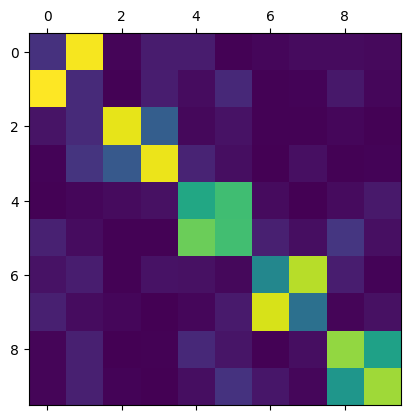

[[6.01330523e-01 7.30017294e-01 3.13504177e-02 6.43326956e-02
  1.53810893e-02 2.38263393e-02 8.17824544e-03 1.51805905e-02
  1.95250133e-02 2.25999801e-02]
 [7.80593861e-01 7.06623584e-01 5.68680176e-02 1.35477655e-02
  5.97207193e-03 5.68453935e-03 4.22829483e-02 6.49400586e-02
  1.12288064e-02 1.03573036e-02]
 [4.59521792e-02 1.09063005e-01 1.45108697e-01 1.00407907e+00
  6.51804498e-02 3.26806211e-02 8.68040448e-03 4.52666810e-02
  3.40338459e-02 2.06409668e-02]
 [4.16171903e-02 3.74562200e-02 9.46295453e-01 1.29090298e-01
  2.47266005e-02 5.60671428e-02 6.41495321e-04 3.90867634e-02
  4.22386855e-02 1.15478322e-02]
 [1.43938915e-02 1.49576078e-02 2.28148908e-03 7.50176196e-02
  3.86445915e-01 8.92446034e-01 1.08169473e-01 2.53328970e-02
  1.04943309e-02 2.92099481e-02]
 [1.58177864e-02 1.52848654e-02 3.94872180e-02 1.06099018e-02
  9.12386642e-01 4.50381251e-01 7.88927554e-03 5.86088818e-02
  1.22059380e-01 4.37041314e-02]
 [1.26889070e-02 2.25262934e-02 5.68208455e-02 2.49480706e

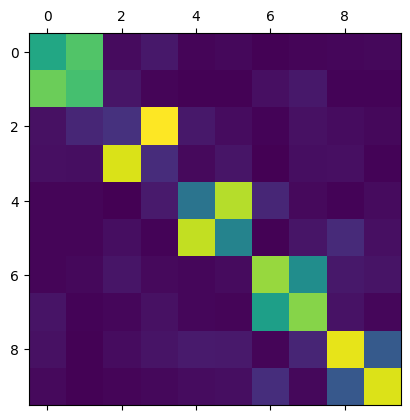

[[3.39492968e-01 8.24639889e-01 1.36673386e-02 5.87366535e-02
  7.17518353e-04 1.98368763e-02 3.16064948e-02 1.38502484e-02
  6.40178581e-04 4.26271657e-02]
 [9.35338838e-01 4.62951662e-01 2.27394784e-02 1.02147358e-01
  3.43341572e-02 1.29646541e-02 3.49728178e-02 1.13407498e-02
  1.32214997e-02 4.96015373e-02]
 [6.80535098e-03 9.01340026e-02 6.69219409e-01 7.72033707e-01
  1.90105166e-02 8.49879193e-03 3.31251933e-03 1.46964726e-02
  2.36533685e-02 5.43740119e-02]
 [2.48746135e-02 2.33774038e-01 7.65758923e-01 6.44464696e-01
  9.65469546e-02 7.30241885e-03 9.41917968e-03 1.19383485e-02
  9.88148105e-03 5.19535548e-02]
 [1.11257038e-01 5.18565485e-02 3.42744744e-02 5.63032218e-02
  8.69252890e-01 5.37733263e-01 9.79123419e-02 2.87097864e-02
  1.02575025e-01 7.72775794e-02]
 [4.49590371e-02 8.71965469e-02 6.47437545e-04 3.08956136e-02
  5.60018386e-01 8.25716826e-01 3.49694545e-02 3.44286061e-02
  3.09520781e-02 1.41938620e-01]
 [4.39239684e-03 5.61428011e-02 2.35084318e-02 1.53617298e

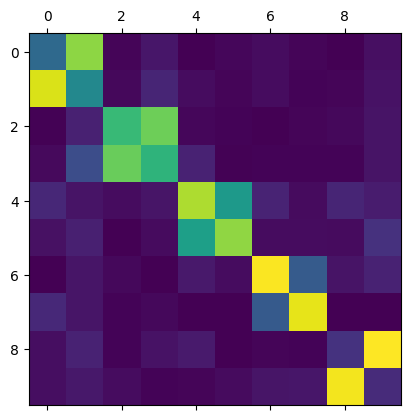

[[1.72512358e-01 9.90043191e-01 8.78952036e-03 8.61819095e-02
  3.17114921e-02 1.32367625e-02 2.13589750e-02 2.57696534e-03
  2.99339552e-02 2.29509948e-02]
 [9.82953309e-01 1.20671416e-01 4.45516601e-02 8.41096412e-02
  4.23407684e-03 1.07018518e-02 8.76017393e-03 1.20381023e-02
  3.24873123e-02 5.06083990e-02]
 [1.20977583e-01 2.41318060e-02 9.54259820e-01 2.89920292e-01
  5.04992507e-02 1.45578211e-02 7.00738641e-03 5.12961775e-03
  1.67998668e-02 7.29044299e-02]
 [8.97130319e-02 2.98279857e-02 2.75584065e-01 9.60924117e-01
  8.52982759e-02 2.39945849e-02 3.21774910e-02 9.75552553e-04
  1.30786022e-02 3.36445764e-02]
 [5.11236154e-02 1.48427574e-02 8.52704669e-03 6.38517879e-02
  6.86489869e-01 7.49119840e-01 6.89999616e-02 3.15026476e-02
  1.10786855e-01 4.98944427e-02]
 [1.50340338e-02 5.94017172e-03 1.15392998e-02 4.99700973e-02
  7.69008911e-01 6.15252887e-01 2.94487475e-05 2.18986936e-02
  9.34082925e-03 4.79359054e-02]
 [5.12072849e-02 5.91797489e-02 1.96003603e-03 3.03753976e

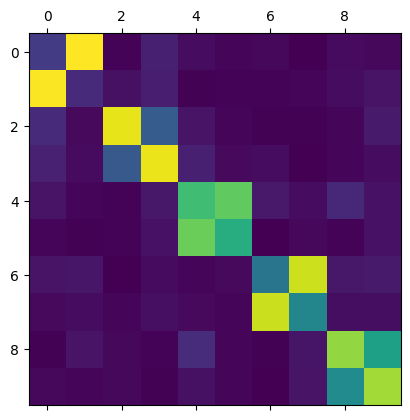

[[1.00000000e+00 6.42583238e-17 1.48022358e-17 1.35022952e-16
  2.52259058e-18 3.67513180e-17 9.56933542e-17 5.36428009e-17
  1.53963870e-16 8.69803149e-17]
 [1.84722916e-17 1.00000000e+00 9.81978665e-19 1.16182140e-16
  3.00158763e-17 1.34844946e-16 3.84535922e-17 1.71149878e-16
  3.00883294e-17 8.59529605e-17]
 [2.95965508e-17 1.35486131e-17 1.00000000e+00 7.14927397e-17
  2.03442285e-17 1.64562148e-16 1.71961871e-16 3.63329811e-17
  7.12315994e-17 6.51403711e-17]
 [9.67353775e-18 3.00121608e-17 3.19098470e-17 1.00000000e+00
  2.24270194e-17 1.60653681e-17 6.93144941e-17 6.90039971e-17
  5.65092188e-17 7.87112001e-17]
 [1.34260469e-17 5.14391098e-17 1.70929175e-17 1.34985548e-17
  1.00000000e+00 6.08698972e-18 9.00626008e-17 1.04811819e-16
  1.42108792e-16 2.95711873e-17]
 [2.84978064e-17 1.34478770e-17 4.42155948e-17 6.84939768e-17
  4.21769548e-17 1.00000000e+00 1.71967878e-16 1.39725975e-16
  7.12477463e-17 1.02192709e-16]
 [8.20007554e-17 1.30236701e-17 1.32748331e-16 1.86721150e

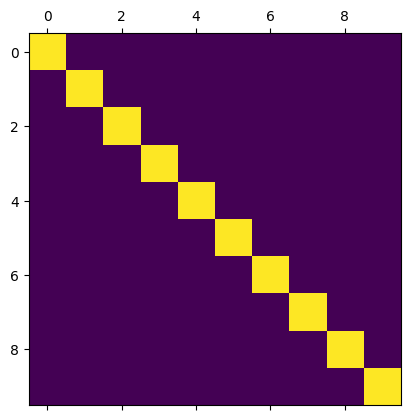

[[0.82030106 0.54592874 0.00868564 0.06227277 0.04304726 0.02283596
  0.0438316  0.00937559 0.06394155 0.04025373]
 [0.54295337 0.87869373 0.09231483 0.09555199 0.00971929 0.01423246
  0.02950752 0.05130018 0.03920518 0.02332393]
 [0.09015997 0.10756166 0.43115031 0.92933133 0.02571494 0.00808017
  0.02625658 0.03396724 0.13287083 0.04161563]
 [0.02600478 0.06147048 0.8843703  0.38984279 0.06411412 0.00807175
  0.04978311 0.01092232 0.0150915  0.07112976]
 [0.04267694 0.00608761 0.0256134  0.02655459 0.96693012 0.26972576
  0.02663484 0.05197161 0.12438519 0.10112397]
 [0.04004564 0.02282767 0.00195224 0.00803837 0.27986567 0.94999952
  0.02871729 0.04176463 0.07126554 0.09156992]
 [0.06894035 0.03489246 0.00829271 0.01378546 0.01971855 0.00970647
  0.09346905 1.01040029 0.0213696  0.08461905]
 [0.02911996 0.01106419 0.01163905 0.03939901 0.01238806 0.00762915
  0.98631703 0.18919519 0.03234366 0.21142088]
 [0.0423751  0.00970429 0.01534056 0.03529347 0.03817459 0.00960103
  0.00498602

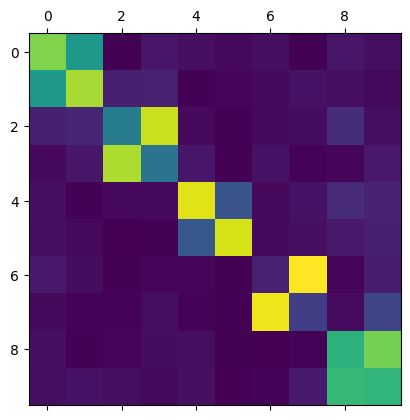

[[9.86925729e-01 2.00152755e-02 1.85325250e-02 4.73883150e-03
  5.79511351e-02 2.16595406e-02 3.60565440e-03 9.18247673e-03
  4.48379887e-02 6.35410010e-02]
 [1.65037431e-02 9.95482792e-01 3.30223392e-02 2.00603867e-01
  1.91679846e-02 1.97126459e-03 1.51763182e-02 1.70854028e-02
  2.38087802e-02 3.46289198e-03]
 [8.49875077e-02 1.19165300e-01 1.02591690e+00 1.15937736e-02
  4.62924439e-02 2.56188615e-02 1.60380918e-02 2.34720220e-02
  9.75200474e-02 7.06301042e-02]
 [1.52446463e-01 1.17611123e-01 1.41511775e-03 9.70131511e-01
  1.08935153e-01 2.06996199e-02 4.05943689e-02 4.61235834e-02
  3.72893960e-02 9.29682308e-02]
 [9.43245102e-03 1.23470690e-02 3.94890525e-03 7.29414797e-02
  1.00556874e+00 2.24958140e-03 8.31686383e-03 1.80838904e-02
  1.16917612e-02 1.09968014e-02]
 [4.33032530e-03 3.47925649e-03 1.67275441e-02 1.63304281e-02
  1.17690239e-02 9.92060803e-01 1.01147708e-03 8.79669229e-03
  8.37441914e-03 6.72915801e-02]
 [5.54729034e-03 1.89105886e-02 5.80533891e-02 3.93778850e

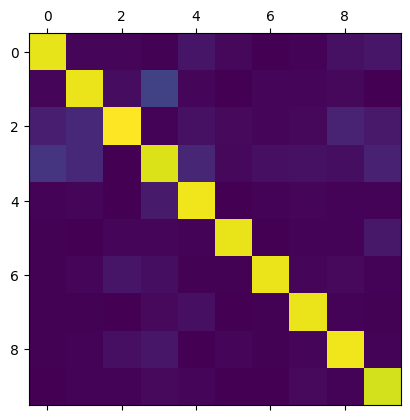

[[7.23658695e-02 9.74634282e-01 2.49850336e-02 6.49368570e-02
  7.22180178e-03 2.02287307e-02 4.08453542e-03 8.05793281e-04
  1.60941185e-02 3.46363172e-03]
 [1.00566919e+00 2.16058763e-01 2.41480930e-02 6.20897392e-02
  2.13705292e-02 2.29657819e-02 3.66144113e-02 3.07590179e-02
  4.30234630e-02 6.97213838e-03]
 [1.01101943e-01 1.14942210e-02 9.41856088e-01 2.69372765e-01
  3.34767436e-03 2.16325067e-02 3.26083542e-03 6.79189195e-02
  5.69280163e-02 5.59695396e-03]
 [1.25435463e-01 1.80345525e-02 2.94253224e-01 9.76810080e-01
  4.78179407e-02 5.21576856e-02 5.61643073e-02 6.07765434e-02
  2.78811607e-02 6.38509810e-03]
 [2.31067896e-02 1.78469311e-02 2.85445507e-03 1.03945567e-02
  6.06637023e-01 7.41315977e-01 3.93857576e-02 2.71248231e-02
  9.49383095e-03 5.33350521e-02]
 [1.77319608e-02 3.07466122e-02 3.97897405e-02 1.92666634e-02
  7.66835869e-01 6.93196354e-01 1.01139491e-02 1.00900437e-01
  1.58333432e-01 3.35062860e-02]
 [2.55287862e-02 1.43149613e-02 4.56071842e-02 3.99590730e

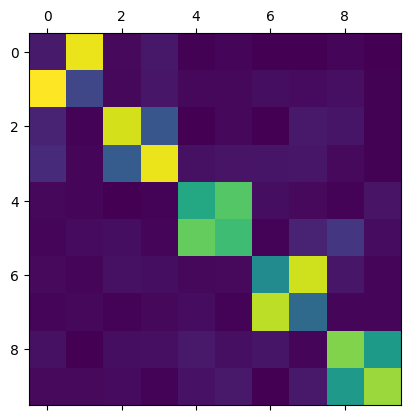

[[1.05692827e-01 9.47970367e-01 1.94168942e-02 7.87025882e-02
  4.32893281e-03 1.23403954e-03 3.03884240e-02 2.39660580e-02
  3.96844917e-02 2.34509540e-03]
 [1.00459063e+00 1.83346236e-01 4.06946359e-02 5.70275672e-02
  2.22837527e-04 8.26407765e-03 3.11952156e-02 1.09200303e-02
  7.70304397e-02 2.15884855e-02]
 [4.50795806e-02 5.89200449e-03 9.63335356e-01 2.93130135e-01
  4.33432964e-02 4.59542710e-02 4.89812720e-03 4.81569295e-03
  8.24192551e-02 4.21911056e-02]
 [1.16766954e-01 1.67542219e-02 2.88053506e-01 9.44716214e-01
  8.28098210e-03 3.33143899e-02 4.74714440e-02 9.56553899e-03
  9.59357275e-02 1.96965702e-02]
 [3.37348172e-02 2.90294785e-02 1.45604191e-02 9.19096291e-03
  6.05271703e-01 7.47357030e-01 2.25956168e-02 4.58523524e-02
  4.20381157e-02 6.24739792e-02]
 [4.05829640e-02 1.09070680e-02 2.18398265e-02 4.50562790e-02
  7.56717563e-01 6.88176254e-01 6.92752834e-02 5.48024035e-02
  1.37510671e-01 2.17840204e-02]
 [5.36279351e-02 2.32767795e-02 7.62189610e-02 2.05887701e

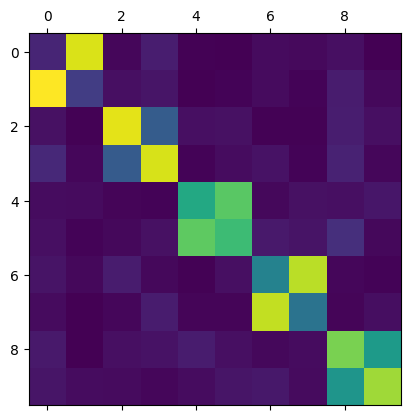

In [78]:
for i in range(10):
    plt.matshow(block_Ms[i])
    print(block_Ms[i])
    plt.show()